<a href="https://colab.research.google.com/github/Yashu2699/Deep_learning/blob/main/Semantic_seg/Ensemble_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models

In [31]:
import tensorflow as tf
import segmentation_models as sm
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import keras
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU
from datetime import datetime
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [6]:
height = 128
widhth = 128
n_classes = 4

train_images = []
for path in glob.glob('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/image_datasets/images/'):
  for image_path in glob.glob(os.path.join(path, '*.tif')):
    img = cv2.imread(image_path, 1)
    train_images.append(img)
train_images = np.array(train_images)

train_masks = []
for path in glob.glob('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/image_datasets/masks_final'):
  for mask_path in glob.glob(os.path.join(path, '*.tif')):
    mask = cv2.imread(mask_path, 0)
    train_masks.append(mask)
train_masks = np.array(train_masks)

In [12]:
from sklearn.preprocessing import LabelEncoder
n, h, w = train_masks.shape
labelencoder = LabelEncoder()
train_masks_reshape = train_masks.reshape(-1,1).ravel()
train_masks_encoded = labelencoder.fit_transform(train_masks_reshape)
train_masks_ = train_masks_encoded.reshape(n, h, w)

In [14]:
train_masks_input = np.expand_dims(train_masks_, axis=3)

from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=0)

In [21]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=n_classes)

y_valid_cat = to_categorical(y_valid, num_classes=n_classes)

In [22]:
activation = 'softmax'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.50), sm.metrics.FScore(threshold=0.50)]

In [ ]:
resnet_backbone = 'resnet34'
preprocess_resnet = sm.get_preprocessing(resnet_backbone)

X_train_resnet = preprocess_resnet(X_train)
X_valid_resnet = preprocess_resnet(X_valid)
X_test_resnet = preprocess_resnet(X_test)

model_resnet = sm.Unet(resnet_backbone, encoder_weights='imagenet',
                       activation=activation, classes=n_classes)

model_resnet.compile(optimizer, total_loss, metrics=metrics)

start = datetime.now()
history_resnet = model_resnet.fit(X_train_resnet, y_train_cat, batch_size=16,
                                  epochs=50, verbose=1,
                                  validation_data=(X_valid_resnet, y_valid_cat))
end = datetime.now()
print('Resnet execution time {}'.format(end-start))

model_resnet.save('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/ensemble_resnet.hdf5')

In [ ]:
inception_backbone = 'inceptionv3'
preprocess_inception = sm.get_preprocessing(inception_backbone)

X_train_inception = preprocess_inception(X_train)
X_valid_inception = preprocess_inception(X_valid)
X_test_inception = preprocess_inception(X_test)

model_inception = sm.Unet(inception_backbone, encoder_weights='imagenet',
                          activation=activation, classes=n_classes)

model_inception.compile(optimizer, total_loss, metrics=metrics)

start = datetime.now()
history_inception = model_inception.fit(X_train_inception, y_train_cat, batch_size=16,
                                        epochs=50, verbose=1,
                                        validation_data=(X_valid_inception, y_valid_cat))
end = datetime.now()
print('Inception execution time {}'.format(end-start))

model_resnet.save('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/ensemble_inception.hdf5')

In [ ]:
vgg_backbone = 'vgg16'
preprocess_vgg = sm.get_preprocessing(vgg_backbone)

X_train_vgg = preprocess_vgg(X_train)
X_valid_vgg = preprocess_vgg(X_valid)
X_test_vgg = preprocess_vgg(X_test)

model_vgg = sm.Unet(vgg_backbone, encoder_weights='imagenet',
                    activation=activation, classes=n_classes)

model_vgg.compile(optimizer, total_loss, metrics=metrics)

start = datetime.now()
history_vgg = model_vgg.fit(X_train_vgg, y_train_cat, batch_size=16,
                            epochs=50, verbose=1,
                            validation_data=(X_valid_vgg, y_valid_cat))
end = datetime.now()
print('Resnet execution time {}'.format(end-start))

model_resnet.save('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/ensemble_vgg.hdf5')

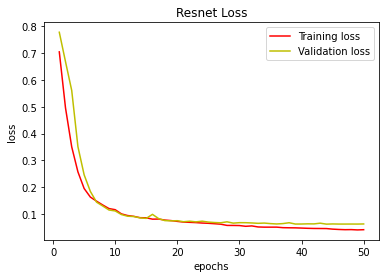

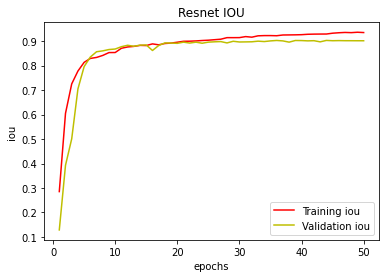

In [27]:
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Resnet Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

iou = history_resnet.history['iou_score']
val_iou = history_resnet.history['val_iou_score']
plt.plot(epochs, iou, 'r', label='Training iou')
plt.plot(epochs, val_iou, 'y', label='Validation iou')
plt.title('Resnet IOU')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()
plt.show()

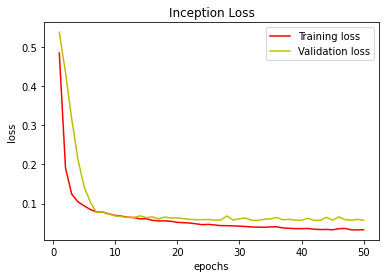

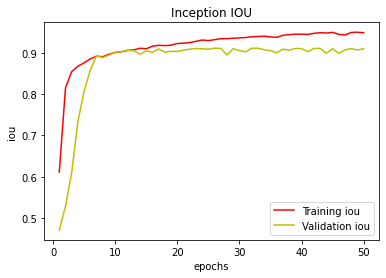

In [28]:
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Inception Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

iou = history_inception.history['iou_score']
val_iou = history_inception.history['val_iou_score']
plt.plot(epochs, iou, 'r', label='Training iou')
plt.plot(epochs, val_iou, 'y', label='Validation iou')
plt.title('Inception IOU')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()
plt.show()

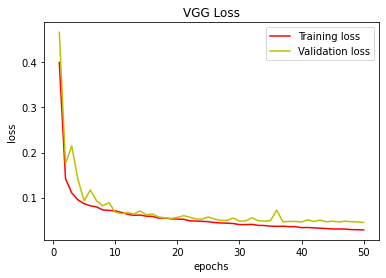

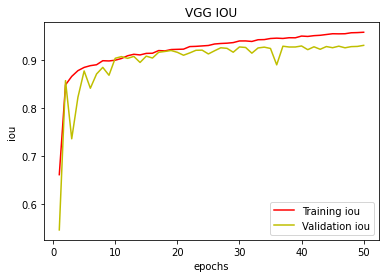

In [29]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('VGG Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

iou = history_vgg.history['iou_score']
val_iou = history_vgg.history['val_iou_score']
plt.plot(epochs, iou, 'r', label='Training iou')
plt.plot(epochs, val_iou, 'y', label='Validation iou')
plt.title('VGG IOU')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()
plt.show()

In [30]:
models = [model_resnet, model_inception, model_vgg]
pred_resnet = model_resnet.predict(X_test_resnet)
pred_inception = model_inception.predict(X_test_inception)
pred_vgg = model_vgg.predict(X_test_vgg)

y_pred_resnet = np.argmax(pred_resnet, axis=3)
y_pred_inception = np.argmax(pred_inception, axis=3)
y_pred_vgg = np.argmax(pred_vgg, axis=3)

preds = np.array([pred_resnet, pred_inception, pred_vgg])

In [40]:
df = pd.DataFrame([])

for w1 in range(0,4):
  for w2 in range(0,4):
    for w3 in range(0,4):
      wts = [w1/10, w2/10, w3/10]
      IOU_wgt = MeanIoU(num_classes=n_classes)
      weighted_preds = np.tensordot(preds, wts, axes=((0), (0)))
      weighted_preds_arg = np.argmax(weighted_preds, axis=3)
      IOU_wgt.update_state(y_test, weighted_preds_arg)
      print('iou for weights: ', w1/10.0, w2/10.0, w3/10.0, ': iou = ',
            IOU_wgt.result().numpy())
      df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                   'wt3':wts[2], 'IOU':
                                   IOU_wgt.result().numpy()},
                                   index=[0]), ignore_index=True)
      
max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2])         

iou for weights:  0.0 0.0 0.0 : iou =  0.033890534
iou for weights:  0.0 0.0 0.1 : iou =  0.933274
iou for weights:  0.0 0.0 0.2 : iou =  0.933274
iou for weights:  0.0 0.0 0.3 : iou =  0.933274
iou for weights:  0.0 0.1 0.0 : iou =  0.9133851
iou for weights:  0.0 0.1 0.1 : iou =  0.93241924
iou for weights:  0.0 0.1 0.2 : iou =  0.9348328
iou for weights:  0.0 0.1 0.3 : iou =  0.93458354
iou for weights:  0.0 0.2 0.0 : iou =  0.9133851
iou for weights:  0.0 0.2 0.1 : iou =  0.92029727
iou for weights:  0.0 0.2 0.2 : iou =  0.93241924
iou for weights:  0.0 0.2 0.3 : iou =  0.9350314
iou for weights:  0.0 0.3 0.0 : iou =  0.9133851
iou for weights:  0.0 0.3 0.1 : iou =  0.91795444
iou for weights:  0.0 0.3 0.2 : iou =  0.9227286
iou for weights:  0.0 0.3 0.3 : iou =  0.93241924
iou for weights:  0.1 0.0 0.0 : iou =  0.90631527
iou for weights:  0.1 0.0 0.1 : iou =  0.93080556
iou for weights:  0.1 0.0 0.2 : iou =  0.9340214
iou for weights:  0.1 0.0 0.3 : iou =  0.93400395
iou for weig

In [41]:
opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]

weighted_preds = np.tensordot(preds, opt_weights, axes=((0),(0)))
weighted_preds_arg = np.argmax(weighted_preds, axis=3)

In [42]:
IOU_resnet = MeanIoU(num_classes=n_classes)
IOU_inception = MeanIoU(num_classes=n_classes)
IOU_vgg = MeanIoU(num_classes=n_classes)
IOU_weighted = MeanIoU(num_classes=n_classes)

IOU_resnet.update_state(y_test, y_pred_resnet)
IOU_inception.update_state(y_test, y_pred_inception)
IOU_vgg.update_state(y_test, y_pred_vgg)
IOU_weighted.update_state(y_test, weighted_preds_arg)

print('IOU for resnet {}'.format(IOU_resnet.result().numpy()))
print('IOU for inception {}'.format(IOU_inception.result().numpy()))
print('IOU for vgg {}'.format(IOU_vgg.result().numpy()))
print('IOU for ensemble {}'.format(IOU_weighted.result().numpy()))

IOU for resnet 0.906315267086029
IOU for inception 0.9133850932121277
IOU for vgg 0.93327397108078
IOU for ensemble 0.9350314140319824


In [62]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

models = [model_resnet, model_inception, model_vgg]

test_img_resnet = preprocess_resnet(test_img_input)
test_img_inception = preprocess_inception(test_img_input)
test_img_vgg = preprocess_vgg(test_img_input)

pred_resnet = model_resnet.predict(test_img_resnet)
pred_inception = model_inception.predict(test_img_inception)
pred_vgg = model_vgg.predict(test_img_vgg)

test_preds = np.array([pred_resnet, pred_inception, pred_vgg])

weighted_preds = np.tensordot(test_preds, opt_weights, axes=((0), (0)))
weighted_preds_arg = np.argmax(weighted_preds, axis=3)[0,:,:]

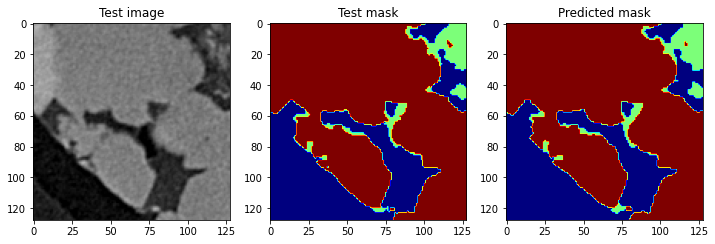

In [63]:
plt.figure(figsize=(12,12))
plt.subplot(231)
plt.title('Test image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Test mask')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Predicted mask')
plt.imshow(weighted_preds_arg, cmap='jet')
plt.show()